<img src=Logo/DIWASA_Logo.png width=150 height=50 aligh="center"/><img src="Logo/DEA_Logo.png" width=150 height=50 align="right"/>

# Summarize actual evapotranspiration statistics across multiple scales

* **Products used:**
  _DE Africa:_
[esa_worldcover_2021](https://explorer.digitalearth.africa/products/esa_worldcover_2021),
  _DIWASA:_
 [AFR_ETa_SSEBop_yearly](https://iwmiwapublic.s3.af-south-1.amazonaws.com/Continental/Africa/Netcdfs/AFR_ETa_SSEBop_yearly.nc)

## Background

Evapotranspiration is a vital component of the hydrological cycle, encompassing the loss of water to the atmosphere through both plant transpiration and evaporation from soil and plant surfaces. An accurate estimation of evapotranspiration is essential for effective water accounting, which is critical for the planning and management of water resources across different scales, including sub-national, national, basin and continental levels.

## Description

This analysis utilizes monthly actual evapotranspiration data from DIWASA to create summaries and visualizations at various spatial levels. These levels may encompass land cover categories, elevation ranges, hydrological units, climatic zones, or administrative units. Some input datasets can be provided by users for summarization and visualization, while others may be accessible from the Digital Earth Africa (DE Africa) repository. For this task, the boundary of the Awash River basin is provided, and the ESA 10 m World Cover land use/land cover data for 2021 is utilized from DE Africa. Users have the option to upload their own area of interest and should adhere to similar attribute names as the sample and codes presented in this jupyter notebook.

In this scenario, the following steps are delineated:

1. Import a shapefile of the Awash River basin boundary. This information is not accessible in DE Africa and must be uploaded to your `Data` directory before proceeding.
2. Import monthly actual evapotranspiration data from the DIWASA public S3 bucket.
3. Compute monthly and annual water consumption based on different land cover types.

## Get started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
#!pip install s3fs h5netcdf datacube rioxarray odc-stac folium mapclassify pystac_client --quiet

In [2]:
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

import matplotlib.pyplot as plt
#from deafrica_tools.dask import create_local_dask_cluster

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from odc.stac import configure_rio, stac_load
from pystac_client import Client

import calendar
from rasterio.enums import Resampling

import warnings
#from rasterstats import zonal_stats
warnings.filterwarnings("ignore")
plt.style.use('ggplot')  # ggplot formatting
pd.set_option("display.precision", 1)
%matplotlib inline

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

### Set analysis parameters
**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
# Set path to shapefile for area of interest
aoi = "data/ETH_AW_Boundary.shp"

# Set path to ETa file on DIWASA AWS S3 public folder
afr_eta = 'https://iwmiwapublic.s3.af-south-1.amazonaws.com/Continental/Africa/Netcdfs/AFR_ETa_SSEBop_yearly.nc'

# set resolution to ~ 100 m
resolution =  100

# Land use/cover data product name
product = 'esa_worldcover_2021'
# Variable name
measurement =  'classification'

# Timestamp
time = ('2021')

### Load geographic area of interest

The spatial extent of this analysis is defined by the Awash basin, represented by a Shapefile. To facilitate data management and analysis, the Shapefile should be initially stored within a designated `Data` folder accessible to the Jupyter Notebook environment. This Shapefile uniquely represents the Awash basin boundary as a single polygon feature, providing a geographic scope for subsequent data extraction and processing.

In [4]:
# Load geographic area of interest
gdf = gpd.read_file(aoi)
gdf.explore()

## Set AWS Endpoint

In [5]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [6]:
# Set a bounding box
# Get Awash river basin bounding box and expand extent by 0.001 degrees
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [gdf.total_bounds[0] + 0.001, gdf.total_bounds[1] + 0.001, gdf.total_bounds[2] + 0.001, gdf.total_bounds[3] + 0.001]

# Set a start and end date
start_date = "2021-01-01"
end_date = "2021-12-31"

# Set the STAC collections
collections = ["esa_worldcover_2021"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 9 datasets


## Load land use/land cover data

This analysis utilizes the 2021 land use and land cover data from the European Space Agency (ESA) World Cover, which has a resolution of 10 meters. The dataset is identified in the DE Africa repository as esa_worldcover_2021. It features a classification system comprising 12 class values, with 0 indicating a no data value. Among these classifications, 8 are relevant to the Awash basin. The accompanying metadata includes a list of the classes, although the descriptive texts for the codes have been shortened for ease of use.

In [7]:
# Set config for DE Africa esa_worldcover
config = {
    "esa_worldcover_2021": {
        "assets": {
            "classification": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1"
            },
        },
    }
}



# Load land use/land cover data
ds = stac_load(
             items,
             output_crs='EPSG:32637', # WGS 1984, UTM Zone 37 N
             bands=measurement,
             resolution=resolution,
             chunks={},
             groupby="solar_day",
             stac_cfg=config,
             bbox=bbox).squeeze().drop_vars('time')

In [8]:
ds

<xarray.Dataset> Size: 28MB
Dimensions:         (y: 4819, x: 5867)
Coordinates:
  * y               (y) float64 39kB 1.355e+06 1.355e+06 ... 8.73e+05 8.73e+05
  * x               (x) float64 47kB 3.852e+05 3.854e+05 ... 9.718e+05 9.718e+05
    spatial_ref     int32 4B 32637
Data variables:
    classification  (y, x) uint8 28MB dask.array<chunksize=(4819, 5867), meta=np.ndarray>

### Clip land use/land cover data to geographic area of interest and plot
The land use and land cover data has been resampled to a resolution of 100 meters, which is the designated resolution for the analysis considered in this notebook. Our focus is on the Awash basin, and therefore, we utilize the Awash basin boundary for masking purposes. The `rioxarray clip` method is employed for this data masking. It is important to note that the basin boundary shapefile is in a geographic coordinate system and must be reprojected to WGS 1984 UTM Zone 37 N (represented by EPSG code 32637) to align with the land use and land cover data.

#### Mask land use/land cover to basin bounday

In [9]:
# Reproject basin boundary to UTM Zone 37 N useing EPSG code 32637
# and mask land use/land cover data using projected basin boundary geometry
lulc = ds.classification.rio.clip(gdf.to_crs('epsg:32637').geometry)
# Maskout areas outside of the basin boundary
lulc = lulc.where(lulc>0)

In [10]:
lulc

<xarray.DataArray 'classification' (y: 4791, x: 5840)> Size: 112MB
dask.array<where, shape=(4791, 5840), dtype=float32, chunksize=(4791, 5840), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 38kB 1.352e+06 1.352e+06 ... 8.73e+05 8.73e+05
  * x            (x) float64 47kB 3.854e+05 3.856e+05 ... 9.692e+05 9.694e+05
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  0

#### Get land use/land cover codes
The metadata dictionary contains the land use/land cover class codes, accessible via the `attrs` attribute. To identify the land use/land cover classes in the basin being analyzed, retrieve the list of attributes from the metadata, extract the unique codes from the data, and compare them.


**_land use/land cover metadata_**

In [11]:
# View classification attributes
ds.classification.attrs = {'units': '1',
'nodata': 0,
'flags_definition': {'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
    '10': 'tree cover',
    '20': 'shrubland',
    '30': 'grassland',
    '40': 'cropland',
    '50': 'built up',
    '60': 'bare/sparse vegetation',
    '70': 'snow and ice',
    '80': 'permanent water bodies',
    '90': 'herbaceous wetland',
    '95': 'mangroves',
    '100': 'moss and lichen'},
  'description': 'Land Use/Land Cover class'}},
'crs': 'EPSG:32637',
'grid_mapping': 'spatial_ref'}

ds.classification.attrs

{'units': '1',
 'nodata': 0,
 'flags_definition': {'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
   'values': {'0': 'no data',
    '10': 'tree cover',
    '20': 'shrubland',
    '30': 'grassland',
    '40': 'cropland',
    '50': 'built up',
    '60': 'bare/sparse vegetation',
    '70': 'snow and ice',
    '80': 'permanent water bodies',
    '90': 'herbaceous wetland',
    '95': 'mangroves',
    '100': 'moss and lichen'},
   'description': 'Land Use/Land Cover class'}},
 'crs': 'EPSG:32637',
 'grid_mapping': 'spatial_ref'}

**_extract codes and descriptions_**

In [12]:
# Get classification code from metadata attributes
lulc_code_dict = ds.classification.attrs['flags_definition']['data']['values']
lulc_code_dict

{'0': 'no data',
 '10': 'tree cover',
 '20': 'shrubland',
 '30': 'grassland',
 '40': 'cropland',
 '50': 'built up',
 '60': 'bare/sparse vegetation',
 '70': 'snow and ice',
 '80': 'permanent water bodies',
 '90': 'herbaceous wetland',
 '95': 'mangroves',
 '100': 'moss and lichen'}

**_get code values from the data_**

In [13]:
# Extract land use/land cover class code from data
lulc_codes = np.unique(lulc.data).astype(np.int16)
# Get non-zero values
lulc_codes = lulc_codes[lulc_codes>0]
# Print these codes - they will be used for plotting
lulc_codes.compute()

array([10, 20, 30, 40, 50, 60, 80, 90], dtype=int16)

#### Build land use/land cover attributes
In order to enhance the visualization and analysis of evapotranspiration for different land use/land cover data, we create pandas dataframe. This dataframe acts as a reference, linking each land use/land cover code to its respective description, a short name used for dataframe columns, and a designated color for visual representation.

**_create short column names_** - create short name for each land use/land cover unit only relevant to the basin under consideration.

In [14]:
# Define short name for each land use/land cover class
col_name = {
    '10': 'Forest',
    '20': 'Shrubland',
    '30': 'Grassland',
    '40': 'Cropland',
    '50': 'Builtup',
    '60': 'Bareland',
    '80': 'Waterbody',
    '90': 'Wetland'
}

**_create land use/land cover attribute dataframe_**

In [15]:
# Build dictionary of code and descriptions based on data codes
lulc_code_dict = {str(code): lulc_code_dict[str(code)] for code in lulc_codes.compute()}
# Create dataframe
lulc_df = pd.DataFrame({
                        # Land use/land cover code
                        'code': lulc_code_dict.keys(),
                        # Land use/land cover description
                        'lulc': lulc_code_dict.values(),
                        # Create color code for each land use/land cover
                        'color': ['#005A32', '#74C473', '#E5FEE0', '#FFF0BE',
                                  '#730000', '#FF0000', '#0070FF', '#BED2FF'],
                        # Create clomn names using lulc class code and labels
                        'col_name': col_name.values()})

In [16]:
lulc_df

,code,lulc,color,col_name
0,10,tree cover,#005A32,Forest
1,20,shrubland,#74C473,Shrubland
2,30,grassland,#E5FEE0,Grassland
3,40,cropland,#FFF0BE,Cropland
4,50,built up,#730000,Builtup
5,60,bare/sparse vegetation,#FF0000,Bareland
6,80,permanent water bodies,#0070FF,Waterbody
7,90,herbaceous wetland,#BED2FF,Wetland


#### Plot masked land use/land cover data

In [17]:
# Create list of hexadecimal color values for shading each
# land use/land cover class
clist = [color for color in lulc_df.color]
# Update colorlist code 70 which is not existent
bl_index = lulc_df.index[lulc_df['code'] == str(60)].tolist()[0]
bl_index = bl_index + 1
clist.insert(bl_index,'#FFFFFF')
# Create color patches and labels
lulc_patches = {row.color: row.lulc.capitalize() for row in lulc_df.itertuples()}
# List of land use/land cover class values
bounds = lulc_df.code.values.astype(np.int8)
# Create colormap
cmap = ListedColormap(clist)

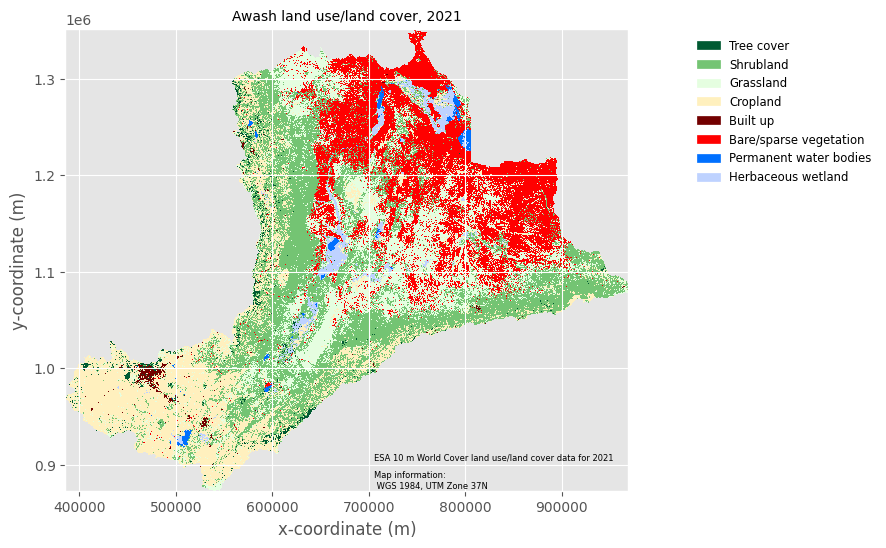

In [18]:
# Create plot area
fig, ax = plt.subplots(figsize=(8,6))
# Create image plot of
ax.imshow(lulc.values,
          cmap=cmap,
          vmin=10,
          vmax=90,
          interpolation='nearest',
          extent=(385450,969350,872850,1351950))

# Create legend color patches and labels
patches = [Patch(color=color,
                 label=label,
                 antialiased=True)
           for color, label in lulc_patches.items()]

# Add legend to the Axes
ax.legend(handles=patches,
          bbox_to_anchor=(1.45, 1),
          fontsize='small',
          facecolor='white',
          edgecolor='white')
# Set axes lebeles
ax.set_xlabel('x-coordinate (m)')
ax.set_ylabel('y-coordinate (m)')
# Add map info to the plot
plt.text(x=705000,y=875500,
         s='Map information:\n WGS 1984, UTM Zone 37N',
         fontdict=dict(fontsize=6))
plt.text(x=705000,y=905000,
         s='ESA 10 m World Cover land use/land cover data for 2021',
         fontdict=dict(fontsize=6))
# Add title to the plot
plt.title('Awash land use/land cover, 2021',fontdict=dict(fontsize=10))

plt.show()

## Load Actual Evapotranspiration
The foundational dataset for this analysis is actual evapotranspiration (ETa) data derived from the Operational Simplified Surface Energy Balance (SSEBop) model, specifically version 5. This dataset serves as input for the generation of Scale Invariant Water Accounting Plus (SIWA+) products. In the context of this notebook, SSEBop ETa data for the year 2021 is used to quantify monthly and annual water consumption patterns across diverse landscape units within the Awash basin.

### Load and preprocess ETa data
The ETa input data requires some preprocessing steps, including converting the datetime format, transforming it to the basin's coordinate reference system, selecting data relevant to the analysis period, clipping it to the basin's boundaries, and masking out no-data values as well as pixel values that fall outside the basin limits.

In [19]:
# Load ETa data
# ds = rxr.open_rasterio(afr_eta, chunks='auto', engine='h5netcdf')
ds = xr.open_dataset(afr_eta, engine = 'h5netcdf')
ds

<xarray.Dataset> Size: 50GB
Dimensions:    (time: 228, latitude: 7579, longitude: 7241)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2021-12-01
  * latitude   (latitude) float32 30kB 37.34 37.33 37.32 ... -34.8 -34.81 -34.82
  * longitude  (longitude) float32 29kB -17.53 -17.52 -17.51 ... 51.4 51.41
Data variables:
    ETa        (time, latitude, longitude) float32 50GB ...
Attributes:
    basin_name:  AFR

In [20]:
# Load ETa data
ds = xr.open_dataset(afr_eta, engine = 'h5netcdf')
# Set spatial reference system (CRS) to match basin CRS
# and select data values for year 2021
ds = ds.rio.write_crs(gdf.crs).sel(time='2021')
# Mask ETa data to basin geometry
ds = ds.rio.clip(gdf.geometry, gdf.crs)
# Mask out areas with value less than or equal to zero.
# This also mask no data values
ds = ds.where(ds>=0)
# Change time coordinates to numpy datetime type
ds.coords['time'] = ds.coords['time'].astype('datetime64[ns]',)
# Set data unit to mm/month
ds.attrs['units'] = 'mm/month'

In [21]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 12, latitude: 454, longitude: 558)
Coordinates:
  * latitude     (latitude) float32 2kB 12.21 12.2 12.19 ... 7.919 7.909 7.899
  * longitude    (longitude) float32 2kB 37.97 37.98 37.99 ... 43.26 43.27 43.27
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 96B 2021-01-01 2021-02-01 ... 2021-12-01
Data variables:
    ETa          (time, latitude, longitude) float32 12MB nan nan ... nan nan
Attributes:
    basin_name:  AFR
    units:       mm/month

### Plot monthly values

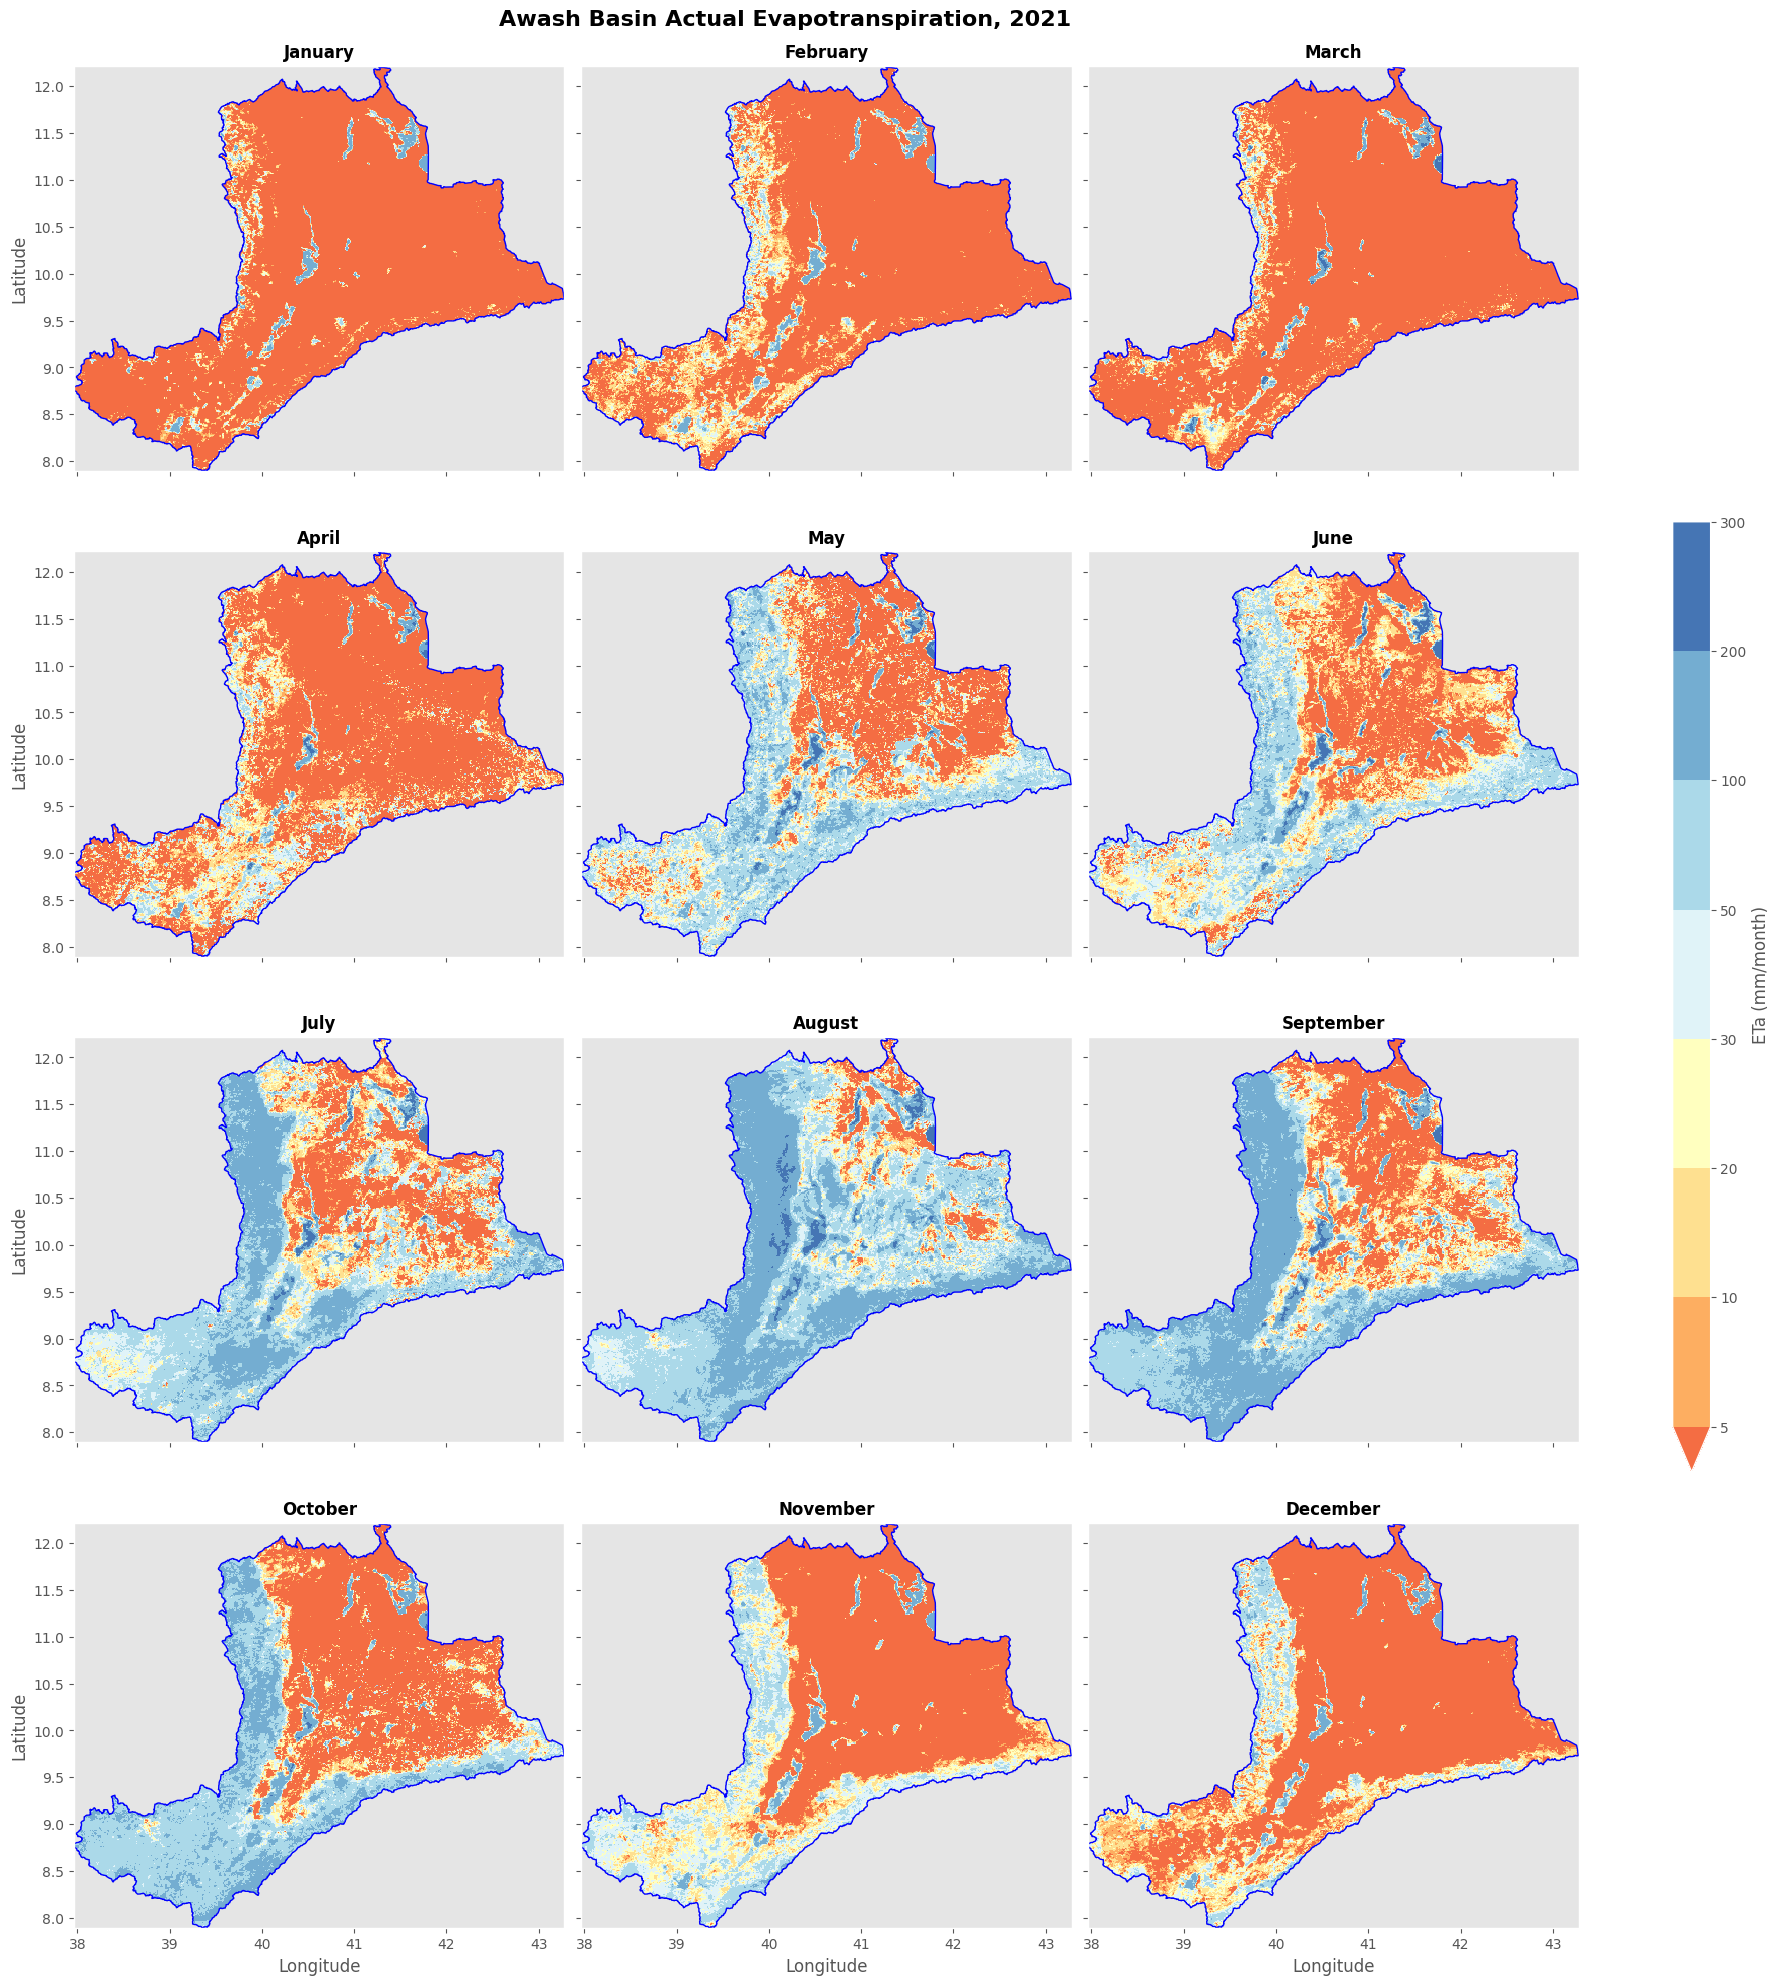

In [22]:
color_list = ['#f46d43','#fdae61','#fee090',
              '#ffffbf','#e0f3f8','#abd9e9','#74add1',
              '#4575b4']
cmap = ListedColormap(color_list)
# Create plot object
g = ds.ETa.plot(size=5,
                     aspect=1.25,
                     col='time',
                     col_wrap=3,
                     sharex=True,
                     cmap=cmap,
                     levels=[5,10,20,30,50,100,200,300],
                     add_colorbar=True,
                     cbar_kwargs={'label': 'ETa (mm/month)',
                                  'location': 'right',
                                  'shrink':0.5,
                                  'aspect': 25})
# Enumerate and iterate through subplots and set title of each
# subplot using month name
for i, ax in enumerate(g.axs.flat):
    i = i + 1
    # Get month name using calendar module
    title = calendar.month_name[i]
    ax.set_title(title, fontdict={
        'fontsize':12,
        'fontfamily':'sans-serif',
        'fontweight':'bold'
    })

    # Set tick label font size
    # Add sub-catchment boundary
    gdf.geometry.boundary.plot(color=None,ax=ax,edgecolor='b',linewidth=1,linestyle='-')

# Add x and y axis title and set font size
g.set_xlabels('Longitude', size=12)
g.set_ylabels('Latitude',size=12)
# Add main title to the plot
plt.suptitle(t='Awash Basin Actual Evapotranspiration, 2021',x=0.4,y=1.0,size=16,weight='bold')
plt.savefig('AW_Montly_ETa.png',dpi=300)
plt.show()

## Compute Statistics
Our objective is to calculate water consumption for various land use and land cover categories within the basin. We have already determined the major classes present in the basin. Prior to initiating the calculations, it is essential to ensure that both the land use/land cover and ETa datasets share a common coordinate reference system and identical spatial resolution.

### Check spatial reference system of both datasets

**_Land use/land cover data_**

In [23]:
# Get the attributes/metadata of the spatial_ref variable
lulc.spatial_ref.attrs

{'crs_wkt': 'PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32637"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / UTM zone 37N',
 'grid_mapping_name': 'transverse_mercator',
 'latitude_of_projection_origin': 0.0,
 'longitude_of_central_meridian': 39.0,
 'fa

**_ETa_**

In [24]:
# Get the attributes/metadata of the spatial_ref variable
ds.spatial_ref.attrs

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'GeoTransform': '37.9664189939653 0.009521936385807058 0.0 12.217691645190678 0.0 -0.00952193173877977'}

It is important to recognize that the land use/land cover (LULC) data is in a projected coordinate system (UTM zone 37N), while the ETa data is presented in a geographic coordinate system. Consequently, we must align the properties of the ETa data with that of the LULC data.

### Reproject ETa data
Reproject ETa data to match the spatial reference system and resolution of land use/land cover data using `rioxarray reproject_match()` method.

In [25]:
# Reproject ETa data to lulc
ds = ds.rio.reproject_match(lulc, resampling=Resampling.nearest)
# Mask area outside of basin boundary
ds = ds.where(ds>=0)

### Compute statistics for each land use/cover type
Before computing statistics on ETa data using lulc, let't compute volume of water consumption at pixel level. The spatial resolution of each pixel is 100 meter and the area of each pixel is 1 hectar (ha), which is equivalent to 0.01$km^2$. The unit of ETa is mm/month or 1.0E-6 km/month.
$$ \text{volume of water consumption} = {ET_a} * 0.01 * 1.0E-6 \text{ }(km^3/month)$$

#### Compute pixel level volume of water consumption

In [26]:
# Compute volume of water consumption in km3/month
ds = ds * 1.0E-6 * 0.01

#### Change lulc data to integer type

In [27]:
# Make sure lulc codes are integer data type
lulc = lulc.astype(np.int16)

#### Compute statistics and create dataframe

In [28]:
# Create empty dataframe
df = pd.DataFrame()
# Enumerate lulc codes and iterate through the list
for i,code in enumerate(lulc_codes.compute()):
    # Get pixels for all months that corresponds to lulc class code
    da = ds.where(lulc==code)
    # Sum all pixel values of ETa and change to pandas dataframe
    ndf = da.sum(dim=['y','x']).to_dataframe().drop('spatial_ref', axis=1)
    # Rename the column name to the corresponding lulc class name/label
    ndf.rename(columns={'ETa':col_name[str(code)]}, inplace=True)
    if i == 0:
        df = ndf
        continue
    df = pd.concat([df,ndf],axis=1)
# Compute monthly values
df['Month_Total'] = df.sum(axis=1)

In [29]:
df.round(2)

,Forest,Shrubland,Grassland,Cropland,Builtup,Bareland,Waterbody,Wetland,Month_Total
time,,,,,,,,,
2021-01-01,4.0e-02,0.1,2.0e-02,7.0e-02,0.0e+00,1.0e-02,8.0e-02,0.2,0.5
2021-02-01,5.0e-02,0.3,6.0e-02,2.3e-01,1.0e-02,2.0e-02,9.0e-02,0.2,1.0
2021-03-01,4.0e-02,0.2,3.0e-02,1.3e-01,1.0e-02,2.0e-02,1.1e-01,0.2,0.7
2021-04-01,5.0e-02,0.4,1.3e-01,3.2e-01,1.0e-02,4.0e-02,1.0e-01,0.2,1.3
2021-05-01,1.1e-01,1.9,6.7e-01,1.1e+00,3.0e-02,2.1e-01,1.2e-01,0.3,4.5
2021-06-01,1.0e-01,1.8,5.2e-01,8.8e-01,2.0e-02,2.4e-01,1.3e-01,0.4,4.0
2021-07-01,1.3e-01,2.8,9.7e-01,1.6e+00,4.0e-02,5.0e-01,1.2e-01,0.4,6.5
2021-08-01,1.5e-01,3.8,1.9e+00,2.0e+00,4.0e-02,1.1e+00,1.3e-01,0.5,9.5
2021-09-01,1.6e-01,3.0,9.3e-01,2.3e+00,5.0e-02,3.2e-01,1.2e-01,0.4,7.2


### Compute annual values and plot bar chart

In [30]:
# Compute annual values
annual = pd.DataFrame(df.loc[:,'Forest':'Wetland'].sum(axis='rows')).reset_index()
# Rename columns
annual.rename(columns={'index':'col_name',0:'Annual ETa in km3'},inplace=True)

In [31]:
# Compute percentage of water consumption
annual['% Consumption'] = (annual['Annual ETa in km3']/annual['Annual ETa in km3'].sum() * 100)
annual

,col_name,Annual ETa in km3,% Consumption
0,Forest,1.1,2.6
1,Shrubland,17.6,40.2
2,Grassland,5.9,13.4
3,Cropland,11.7,26.7
4,Builtup,0.3,0.7
5,Bareland,2.6,5.8
6,Waterbody,1.3,2.9
7,Wetland,3.3,7.6


In [32]:
annual = lulc_df.merge(annual,on='col_name').sort_values(by='Annual ETa in km3')


#### Plot barchart

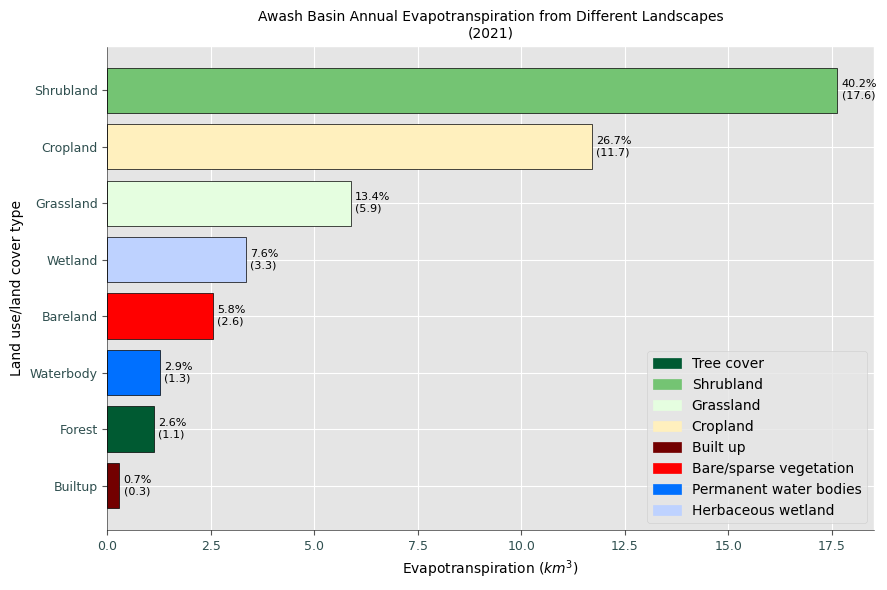

In [33]:
# Create plot canvas and axes
fig,ax = plt.subplots(figsize=(9,6))
# Plot bar chart
bars = ax.barh(annual['col_name'],
        annual['Annual ETa in km3'],
        color=annual.color,
        edgecolor='black', hatch='',
        label=annual['% Consumption'] )
# Set axis labels
ax.set_ylabel('Land use/land cover type', fontsize=10,color='k')
ax.set_xlabel('Evapotranspiration ($km^3$)', fontsize=10,color='k')
ax.tick_params(axis='both',labelsize=9, labelcolor='DarkSlateGray')
# Set title
plt.title('Awash Basin Annual Evapotranspiration from Different Landscapes\n(2021)',
          fontdict=dict(fontsize=10))
# Get legend labels and create patches
colors = list(lulc_patches.keys())
handles = [Patch(color=color,label=lulc_patches[color],edgecolor='k') for color in colors]
plt.legend(handles, lulc_df.lulc.str.capitalize())
# Set axes parameters
ax.spines[['left','bottom']].set_color('k')
ax.spines[['left','bottom']].set_linewidth(0.4)

for bar, perc, value in zip(bars, annual['% Consumption'].values,
                     annual['Annual ETa in km3'].values):
    width = bar.get_width()
    ax.text(width + 0.1,bar.get_y() + bar.get_height()/2,
            f'{perc:.1f}%\n({value:.1f})',
            ha='left',
            va='center',
            fontsize=8)

fig.tight_layout()
#fig.dpi=600
fig.savefig('ETa_Awash.png')
plt.show()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data `and DIWASA data` are licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [34]:
print(datacube.__version__)

1.9.3


**Last Tested:**

In [35]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-05-04'